In [1]:
import cv2
import numpy as np
import time
from openvino.inference_engine import IENetwork, IECore
import sys
import os
import argparse

class face_detect:
    '''
    Class for the Face Detection Model.
    '''
    def __init__(self, model_name, device='CPU', extensions=None):
        
        self.model_weights = model_name+'.bin'
        self.model_structure = model_name+'.xml'
        #print(self.model_weights)
        self.device = device
        #raise NotImplementedError

    def load_model(self): 
        
        self.model = IENetwork(self.model_structure,self.model_weights)
      
        self.input_name=next(iter(self.model.inputs))
        self.input_shape=self.model.inputs[self.input_name].shape
        self.output_name=next(iter(self.model.outputs))
        self.output_shape=self.model.outputs[self.output_name].shape
        
        core = IECore()
        self.network = core.load_network(network=self.model,device_name=self.device, num_requests=1)
        print('Model loaded successfully')
        #raise NotImplementedError

    def predict(self, image_inp):
      
        net_input = self.preprocess_input(image_inp)
        infer_request_handle = self.network.start_async(request_id=0, inputs=net_input)
        if infer_request_handle.wait() == 0:
            net_output = infer_request_handle.outputs[self.output_name]
            #print(np.shape(net_output))
            boxes = self.preprocess_output(net_output)
        return self.draw_outputs(boxes, image_inp)


    def preprocess_input(self, image):
        input_image = cv2.resize(image, (self.input_shape[3], self.input_shape[2]))
        input_image = input_image.transpose((2, 0, 1))
        input_image = input_image.reshape(1, *input_image.shape)
        return {self.input_name: input_image}

        
    def draw_outputs(self, coords, image):
 
        w = image.shape[1]
        h = image.shape[0]
        boxes = []
        for box in coords:
            p1 = (int(box[0] * w), int(box[1] * h))
            p2 = (int(box[2] * w), int(box[3] * h))
            boxes.append([p1[0], p1[1], p2[0], p2[1]])
            image = cv2.rectangle(image, p1, p2, (0, 0, 255), 3)
            crp_img = image[p1[1]:p2[1],p1[0]:p2[0]]
        return boxes,image,crp_img

    def preprocess_output(self, outputs):
        self.threshold = 0.5
        boxes = []
        probs = outputs[0, 0, :, 2]
        for i, p in enumerate(probs):
            if p > self.threshold:
                box = outputs[0, 0, i, 3:]
                boxes.append(box)
        return boxes

    
#if __name__ == '__main__':
#    print('main_program')
    

Model loaded successfully


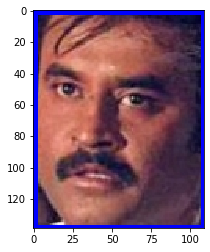

In [2]:
path_fd = '/home/somasundaram/Desktop/computer_pointer_controller/intel/face-detection-adas-binary-0001/FP32-INT1/face-detection-adas-binary-0001'
fd = face_detect(path_fd)
fd.load_model()
img = cv2.imread('rajini.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_1 = img.copy()
_,pre_img,crp_img=fd.predict(img)

import matplotlib.pyplot as plt
plt.imshow(crp_img)

In [20]:
import cv2
cap = cv2.VideoCapture('demo.mp4')

path_fd = '/home/somasundaram/Desktop/computer_pointer_controller/intel/face-detection-adas-binary-0001/FP32-INT1/face-detection-adas-binary-0001'
fd = face_detect(path_fd)
fd.load_model()

path_ld = '/home/somasundaram/Desktop/computer_pointer_controller/intel/landmarks-regression-retail-0009/FP16/landmarks-regression-retail-0009'
ld = landmark(path_ld)
ld.load_model()

path_hdps = '/home/somasundaram/Desktop/computer_pointer_controller/intel/head-pose-estimation-adas-0001/FP16/head-pose-estimation-adas-0001'
hp = head_pose(path_hdps)
hp.load_model()

gaze_path = '/home/somasundaram/Desktop/computer_pointer_controller/intel/gaze-estimation-adas-0002/FP16/gaze-estimation-adas-0002'
gz = gaze(gaze_path)
gz.load_model()



while(cap.isOpened()):
    ret,frame = cap.read()
    if ret == True:
        #img = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        boxes,pre_img,crp_img = fd.predict(frame)
        keypoint_image,right_eye,left_eye,x_e,y_e = ld.predict(crp_img)
        hp_vector = hp.predict(crp_img)
        hp_vector = np.reshape(hp_vector,(1,3))
        mouse_points = gz.predict(left_eye,right_eye,hp_vector)
        
        # rotation vector
        rvec = np.array([0, 0, 0], np.float)
        # translation vector
        tvec = np.array([0, 0, 0], np.float)
        # camera matrix
        camera_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], np.float)
        
        result, _ = cv2.projectPoints(mouse_points, rvec, tvec, camera_matrix, None)
        result = result[0][0]
        
        res = (int(result[0] * 100), int(result[1] * 100))
        
        e1 = (boxes[0][0]+x_e[0],boxes[0][1]+y_e[0])
              
        e2 = (boxes[0][0]+x_e[1],boxes[0][1]+y_e[1])
               

        cv2.arrowedLine(pre_img, e1, (e1[0] - res[0], e1[1] + res[1]), (0, 255, 0), 2)
        cv2.arrowedLine(pre_img, e2, (e2[0] - res[0], e2[1] + res[1]), (0, 255, 0), 2)
       
        #print(boxes)
        #print(result)
        

        cv2.imshow('frame',pre_img)
        cv2.waitKey(1)
    else:
        break
cap.release()
cv2.destroyAllWindows()
        



Model loaded successfully
Model loaded successfully
Head pose model loaded successfully
Gaze model loaded successfully


In [5]:
cap.isOpened()

True

In [5]:
class landmark(face_detect):
    
    def predict(self, image):
        self.img = image
        net_input = self.preprocess_input(self.img)
        infer_request_handle = self.network.start_async(request_id=0, inputs=net_input)
        if infer_request_handle.wait() == 0:
            self.net_output = infer_request_handle.outputs[self.output_name]
            self.x,self.y = self.find_points()
            right_eye,left_eye = self.crop_eyes(self.x,self.y)
            
            img_circle = self.draw_circle()
            return(img_circle,right_eye,left_eye,self.x,self.y)
           
    
    def find_points(self):
        h,w,_ = np.shape(self.img)
        x=[]
        y=[]
        for i,j in enumerate(np.squeeze(self.net_output)):
            if (i+1)%2 == 0:
                y.append(int(j*h))
            else:
                x.append(int(j*w))
        return(x,y)
    
    def draw_circle(self):
        for i in range(2):
            cv2.rectangle(self.img,(self.x[i]-30,self.y[i]-30),(self.x[i]+30,self.y[i]+30),(255,0,0),1)
        return(self.img) 
    
    def crop_eyes(self,x,y):
        right_eye = self.img[y[0]-15:y[0]+15,x[0]-15:x[0]+15]
        left_eye = self.img[y[1]-15:y[1]+15,x[1]-15:x[1]+15]
        return(right_eye,left_eye)
        
        

Model loaded successfully
(30, 30, 3)


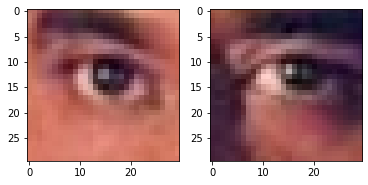

In [21]:
path_ld = '/home/somasundaram/Desktop/computer_pointer_controller/intel/landmarks-regression-retail-0009/FP16/landmarks-regression-retail-0009'
ld = landmark(path_ld)
ld.load_model()
right_eye,left_eye = ld.predict(crp_img)

plt.subplot(121)
plt.imshow(right_eye)
plt.subplot(122)
plt.imshow(left_eye)
print(np.shape(left_eye))


In [3]:
class head_pose(face_detect):
    
    def load_model(self): 

        self.model = IENetwork(self.model_structure,self.model_weights)
        self.input_name=next(iter(self.model.inputs))
        self.input_shape=self.model.inputs[self.input_name].shape
        self.output_name=self.model.outputs.keys()
        self.output = [i for i in self.output_name]
        #print('output_keys',self.output)
        #self.output_shape=np.shape(self.model.outputs.keys())
       

        core = IECore()
        self.network = core.load_network(network=self.model,device_name=self.device, num_requests=1)
        print('Head pose model loaded successfully')
    
    def predict(self, image):
        self.img = image
        net_input = self.preprocess_input(self.img)
        infer_request_handle = self.network.start_async(request_id=0, inputs=net_input)
        if infer_request_handle.wait() == 0:
            self.net_output = [infer_request_handle.outputs[i] for i in self.output]
        return(self.net_output)
    

In [6]:
path_hdps = '/home/somasundaram/Desktop/computer_pointer_controller/intel/head-pose-estimation-adas-0001/FP16/head-pose-estimation-adas-0001'
hp = head_pose(path_hdps)
hp.load_model()
out = hp.predict(crp_img)
out = np.reshape(out,(1,3))
out

Head pose model loaded successfully


array([[ -3.634793 ,  -1.4367086, -10.419838 ]], dtype=float32)

In [13]:
out

array([[ -3.634793 ,  -1.4367086, -10.419838 ]], dtype=float32)

In [4]:
class gaze(face_detect):
    
    def load_model(self): 
        self.input_shapes=[]
        self.model = IENetwork(self.model_structure,self.model_weights)
        self.input_names=[i for i in iter(self.model.inputs)]
        for i in self.input_names:
            self.input_shapes.append(self.model.inputs[i].shape)
            
        self.output_name = next(iter(self.model.outputs))
      
        core = IECore()
        self.network = core.load_network(network=self.model,device_name=self.device, num_requests=1)
        print('Gaze model loaded successfully')
        
        
    def preprocess_input(self, left_eye_image,right_eye_image,head_pose_angles):
        #print(np.shape(left_eye_image))
        left_eye_image = cv2.resize(left_eye_image, (self.input_shapes[1][3], self.input_shapes[1][2]))
        right_eye_image = cv2.resize(right_eye_image, (self.input_shapes[1][3], self.input_shapes[1][2]))
        
        left_eye_image = left_eye_image.transpose((2, 0, 1))
        right_eye_image = right_eye_image.transpose((2, 0, 1))
        
        left_eye_image = left_eye_image.reshape(1, *left_eye_image.shape)
        right_eye_image = right_eye_image.reshape(1, *right_eye_image.shape)
        return {self.input_names[0]:head_pose_angles,self.input_names[1]:left_eye_image,self.input_names[2]:right_eye_image}
        
    
    def predict(self, left_eye_image,right_eye_image,head_pose_angles):
        #self.img = image
        net_input = self.preprocess_input(left_eye_image,right_eye_image,head_pose_angles)
        infer_request_handle = self.network.start_async(request_id=0, inputs=net_input)
        if infer_request_handle.wait() == 0:
            self.net_output = infer_request_handle.outputs[self.output_name]
        return(self.net_output)

In [32]:
gaze_path = '/home/somasundaram/Desktop/computer_pointer_controller/intel/gaze-estimation-adas-0002/FP16/gaze-estimation-adas-0002'
gz = gaze(gaze_path)
gz.load_model()
gz.predict(left_eye,right_eye,out)

Gaze model loaded successfully
(30, 30, 3)


array([[ 0.11144523,  0.12191229, -0.9697769 ]], dtype=float32)

In [1]:
%%writefile movemouse.py

import pyautogui
import argparse

class MouseController:
    def __init__(self, precision, speed):
        precision_dict={'high':100, 'low':1000, 'medium':500}
        speed_dict={'fast':1, 'slow':10, 'medium':5}

        self.precision=precision_dict[precision]
        self.speed=speed_dict[speed]

    def move(self, position):
        print(position)
        x,y=position
        print(x*2,y*2)
        #pyautogui.moveRel(x*self.precision, -1*y*self.precision, duration=self.speed)
        pyautogui.moveTo(x,y,self.speed)
        pyautogui.doubleClick()
        
    
        
    

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--speed',default='medium')
    parser.add_argument('--precision',default='medium')
    parser.add_argument('--position',default=(50,50))
    args = parser.parse_args()
    
    mc = MouseController(args.precision,args.speed)
    mc.move(args.position)

Overwriting movemouse.py


In [6]:
#z=(50,50)
!python movemouse.py 

(50, 50)
100 100


In [59]:
pyautogui.size()
pyautogui.moveTo(1048,54,5)

In [10]:
x,y= (100,200)

In [ ]:
%%writefile argpar.py

import argparse
parser = argparse.ArgumentParser(description ='Taking inputs for face detection model')
parser.add_argument('-m',required=True)
args = parser.parse_args()
print(args.m)

In [ ]:
pp = {'som':[1,2,3],'shiv':[[1,2,3],[4,5,6]]}

In [ ]:
for i in pp.values():
    print(i)

In [ ]:
out = cP1.check()
out.__dict__

In [11]:
MLB_team = dict([
     ('Colorado', 'Rockies'),
     ('Boston', 'Red Sox'),
     ('Minnesota', 'Twins'),
     ('Milwaukee', 'Brewers'),
     ('Seattle', 'Mariners')
 ])

In [19]:
for i in iter(MLB_team):
    print(MLB_team[i])

Rockies
Red Sox
Twins
Brewers
Mariners


In [20]:
next(iter(MLB_team))

'Colorado'